In [247]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

In [248]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [249]:
risk = "hi_gauss_blob_risk_fun"

In [250]:
dict = parse_variables('geno_simulation.txt')
G = 10
L = 100
c = 1000
k = 6
M = 20
HWE = 1

very_rare_to_save, rare_to_save, common_to_save, geno = simulate_genos(G, L, c, k, M, HWE)

In [251]:
humans = pd.DataFrame()
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

humans["populations"] = labels_pop

In [252]:
true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(geno, humans)
#true_p2s['pop'] = humans['populations']
#true_q2s['pop'] = humans['populations']
#true_twopqs['pop'] = humans['populations']

# Check PCA

In [253]:
scaler = StandardScaler()
scaled_geno = scaler.fit_transform(geno)
n_components = max(min(geno.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_geno = pca.fit_transform(scaled_geno)
PC_geno = pd.DataFrame(data=PC_geno, columns=pc_labels_complete)

In [254]:
PC_geno['populations'] = humans['populations']

In [255]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [f"pop {i+1}"]*c
populations = pd.DataFrame(labels_pop, columns=['populations'])

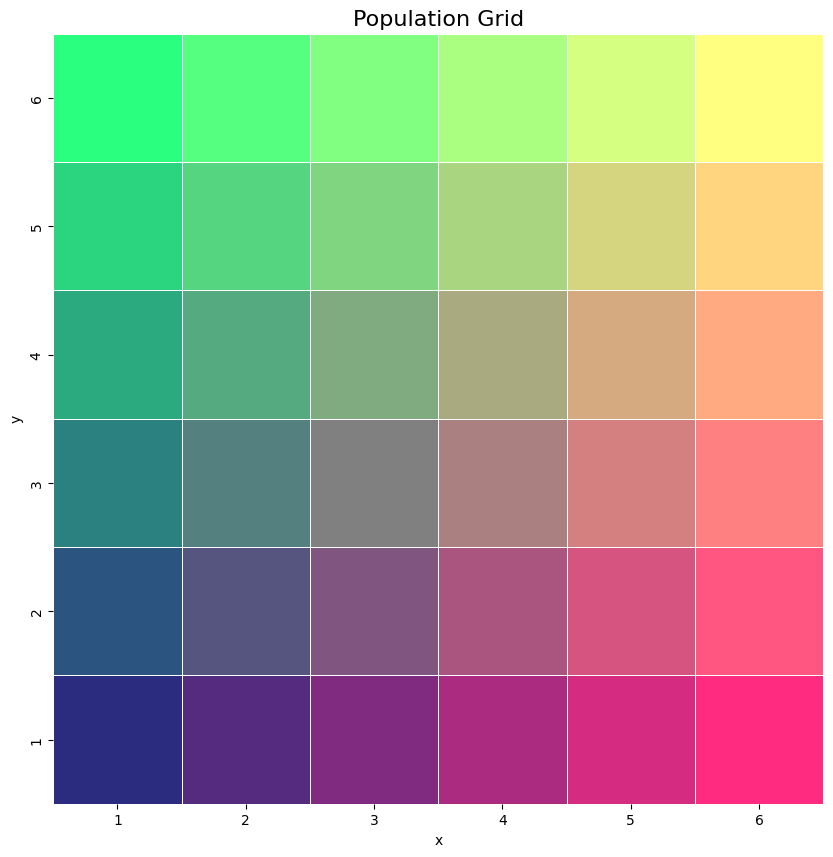

In [256]:
humans
humans['x'] = ((humans['populations'] - 1) % k) + 1
humans['y'] = ((humans['populations'] - 1) // k) + 1
humans['z'] = 0.5
palette = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
df_agg = humans.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

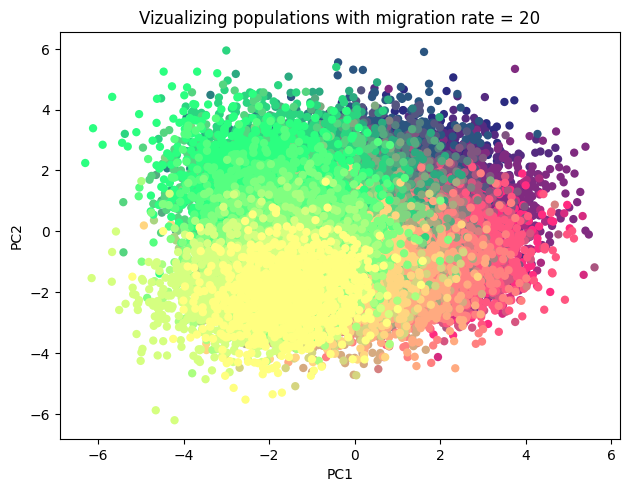

In [257]:
sns.scatterplot(x='PC1', y='PC2', data=PC_geno, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [258]:
# get correction

In [259]:
correction = pd.DataFrame()
for col in geno.columns:
    snp = geno[[col]]
    snp = pd.get_dummies(snp, columns=[col], dtype=int)
    correction[col] = list(geno[col]/(snp[f"{col}_-1.0"]*true_q2s[col] + snp[f"{col}_1.0"]*true_p2s[col] + snp[f"{col}_0.0"]*true_twopqs[col]))

In [260]:
correction

,CG3_AF_0.3733194444444444,CG5_AF_0.2537916666666667,CG7_AF_0.24579166666666666,CG22_AF_0.2767361111111111,CG33_AF_0.25098611111111113,CG37_AF_0.2502083333333333,CG39_AF_0.38856944444444447,CG40_AF_0.2554444444444444,CG47_AF_0.42168055555555556,CG54_AF_0.2041388888888889,...,VRG489_AF_0.04863888888888889,VRG491_AF_0.006625,VRG493_AF_0.002972222222222222,VRG494_AF_0.0025555555555555557,VRG495_AF_0.002638888888888889,VRG496_AF_0.00375,VRG497_AF_0.014180555555555556,VRG498_AF_0.04926388888888889,VRG499_AF_0.007361111111111111,VRG500_AF_0.010861111111111111
0,0.000000,0.000000,2.136752,0.000000,0.000000,0.000000,0.000000,1.615509,0.000000,1.290323,...,1.245330,1.009082,1.002004,1.006036,1.006036,1.003009,1.013171,1.165501,1.015228,1.003009
1,2.967359,0.000000,0.000000,1.996008,2.070393,-18.867925,-4.444444,0.000000,-5.681818,1.290323,...,1.245330,1.009082,1.002004,1.006036,1.006036,1.003009,1.013171,1.165501,1.015228,1.003009
2,0.000000,1.547988,2.136752,0.000000,2.070393,1.739130,3.787879,0.000000,0.000000,1.290323,...,1.245330,1.009082,1.002004,1.006036,1.006036,1.003009,1.013171,1.165501,1.015228,1.003009
3,0.000000,1.547988,0.000000,1.996008,-9.900990,1.739130,0.000000,1.615509,0.000000,1.290323,...,1.245330,1.009082,1.002004,1.006036,1.006036,1.003009,1.013171,1.165501,1.015228,1.003009
4,0.000000,1.547988,0.000000,1.996008,2.070393,0.000000,0.000000,1.615509,0.000000,1.290323,...,1.245330,1.009082,1.002004,1.006036,1.006036,1.003009,1.013171,0.000000,1.015228,1.003009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,0.000000,2.427184,1.362398,1.481481,1.451379,1.272265,1.610306,0.000000,2.100840,1.550388,...,1.012146,1.002004,1.006036,1.008065,1.003009,1.003009,1.037344,1.012146,1.007049,1.018330
35996,0.000000,2.427184,0.000000,1.481481,1.451379,0.000000,0.000000,0.000000,2.100840,0.000000,...,1.012146,1.002004,1.006036,1.008065,1.003009,1.003009,1.037344,1.012146,1.007049,1.018330
35997,-25.000000,0.000000,1.362398,1.481481,1.451379,1.272265,1.610306,2.262443,2.100840,1.550388,...,1.012146,1.002004,1.006036,1.008065,1.003009,1.003009,1.037344,1.012146,1.007049,1.018330
35998,0.000000,2.427184,1.362398,0.000000,1.451379,1.272265,1.610306,2.262443,-9.523810,1.550388,...,1.012146,1.002004,1.006036,1.008065,1.003009,1.003009,1.037344,1.012146,1.007049,1.018330


In [261]:

# Check if any column contains NaN values
nan_columns = correction.isna().any()

# Check if any column contains inf values (both positive and negative inf)
inf_columns = correction.isin([np.inf, -np.inf]).any()

# Combine NaN and inf column checks into one dataframe for easier viewing
nan_inf_summary = pd.DataFrame({
    'NaN': nan_columns,
    'inf': inf_columns
})

# Show the columns that contain NaN or inf values
nan_inf_summary[nan_inf_summary['NaN'] | nan_inf_summary['inf']]

,NaN,inf


In [262]:
# Replace inf values (-inf and inf) with NaN first (to handle both at once)
correction.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now fill NaN values with the corresponding values from the 'complete' dataframe
correction.fillna(geno, inplace=True)


In [263]:
# calibrating
for col in correction.columns:
    X = correction[[col]]
    y = geno[col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[col]
    correction[col] = correction[col]*beta

In [264]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

In [265]:
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
humans['x_temp'] = humans['x']/k
humans['y_temp'] = humans['y']/k
humans[name_risk] = list(humans.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
humans[name_risk] = humans[name_risk].astype('float')

<Axes: xlabel='x', ylabel='y'>

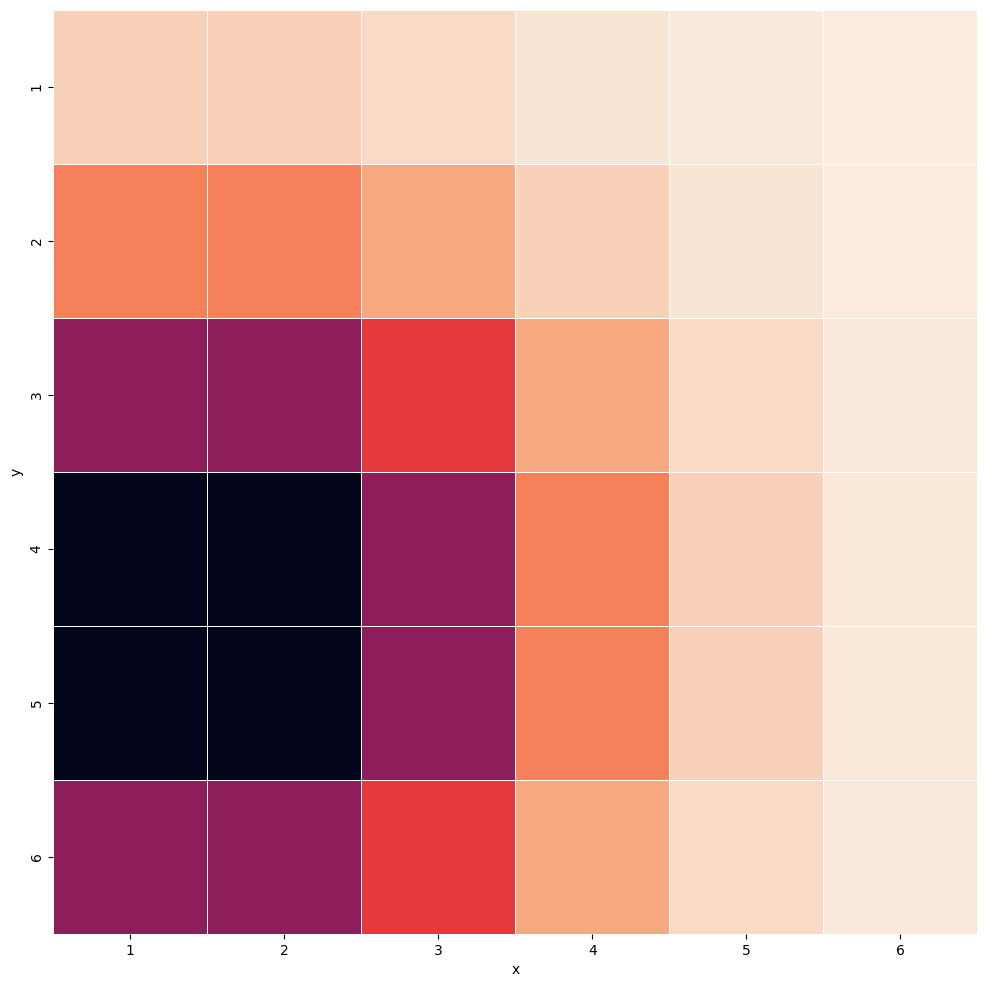

In [266]:
# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [267]:
# check for one

In [268]:
to_check = list(geno.columns)[0]

In [269]:
humans['snp'] = geno[to_check]
humans['pop'] = PC_geno['populations']
humans['risk'] = humans[name_risk]

In [270]:
humans

,populations,x,y,z,x_temp,y_temp,hi_gauss_blob_risk,snp,pop,risk
0,1,1,1,0.5,0.166667,0.166667,0.124353,0.0,1,0.124353
1,1,1,1,0.5,0.166667,0.166667,0.124353,1.0,1,0.124353
2,1,1,1,0.5,0.166667,0.166667,0.124353,0.0,1,0.124353
3,1,1,1,0.5,0.166667,0.166667,0.124353,0.0,1,0.124353
4,1,1,1,0.5,0.166667,0.166667,0.124353,0.0,1,0.124353
...,...,...,...,...,...,...,...,...,...,...
35995,36,6,6,0.5,1.000000,1.000000,0.013476,0.0,36,0.013476
35996,36,6,6,0.5,1.000000,1.000000,0.013476,0.0,36,0.013476
35997,36,6,6,0.5,1.000000,1.000000,0.013476,-1.0,36,0.013476
35998,36,6,6,0.5,1.000000,1.000000,0.013476,0.0,36,0.013476


In [271]:
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

0.00012567236228180553


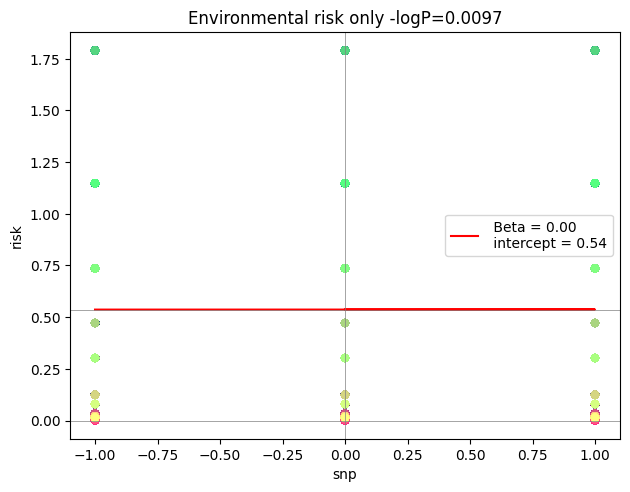

In [272]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, color=palette, linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [273]:
humans['corr'] = correction[to_check]

In [274]:
X = humans[['corr']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['corr']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['corr']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

2.5847379792054426e-16


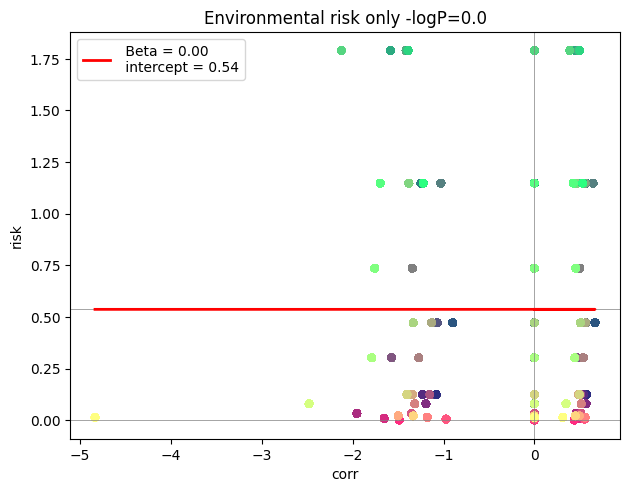

In [275]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='corr', y='risk', data=humans, color=palette, linewidth=0, legend=False)

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['corr'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [276]:
# Go over all the snps

In [277]:
y = humans['risk']
betas_snps = []
betas_mafs_ols = []
intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_mafs_ols = []

In [278]:
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], y)
    beta_mafs_ols = manhattan_linear(correction[[f"{snp}"]], y)

    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

In [279]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_maf'] = betas_mafs_ols

to_compare['logP_snps'] = logP_snps
to_compare['logP_mafs_ols'] = logP_mafs_ols

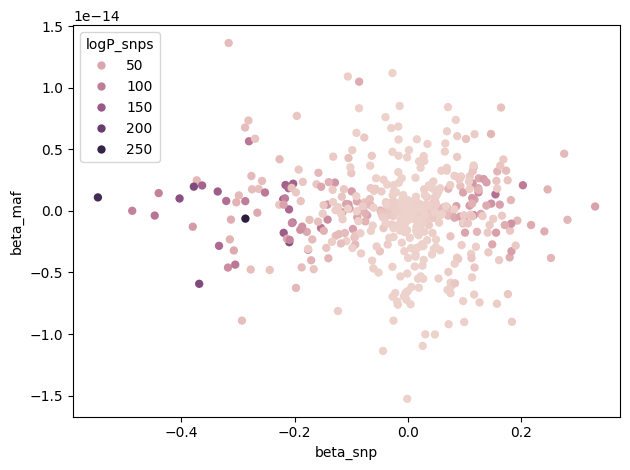

In [280]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'logP_snps',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

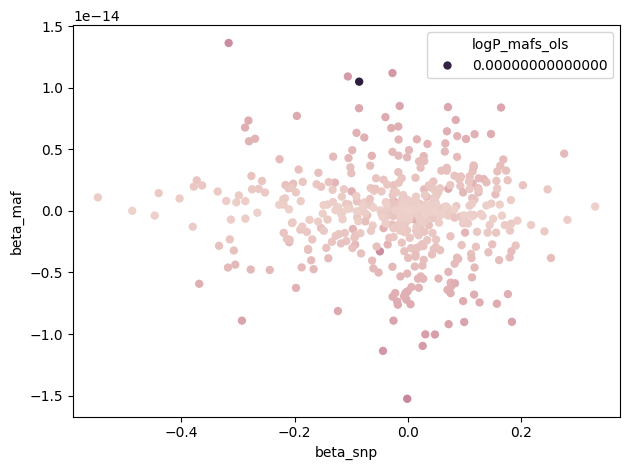

In [281]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'logP_mafs_ols',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

In [282]:
y = humans['risk']
betas_snps = []
betas_correction = []
betas_abyss = []

intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_correction = []
logP_abyss = []

In [283]:
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], y)
    beta_correction = manhattan_linear(correction[[f"{snp}"]], y)
    beta_abyss = manhattan_linear(geno[[snp]], y, true_p2s[[f"{snp}"]]-true_q2s[[f"{snp}"]])
    
    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_correction.append(beta_correction['coefs'][0])
    logP_correction.append(beta_correction['-logPs'][0])
    
    betas_abyss.append(beta_abyss['coefs'][0])
    logP_abyss.append(beta_abyss['-logPs'][0])
    

In [284]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_correction'] = betas_correction
to_compare['beta_abyss'] = betas_abyss


to_compare['logP_snps'] = logP_snps
to_compare['logP_correction'] = logP_correction
to_compare['logP_abyss'] = logP_abyss


In [285]:
betas_long = to_compare[['beta_snp', 'beta_correction', 'beta_abyss']].melt(var_name='Beta_Type', value_name='Beta_Value')
#betas_long = to_compare[['beta_snp', 'beta_abyss']].melt(var_name='Beta_Type', value_name='Beta_Value')


In [286]:
betas_long['True_Beta'] = 0

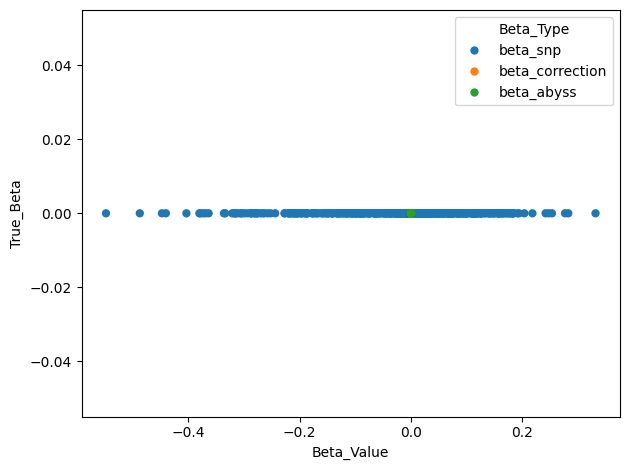

In [287]:
sns.scatterplot(x='Beta_Value', y='True_Beta',data=betas_long, hue= 'Beta_Type',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

In [288]:
# causality of SNPs

In [289]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

def multi(arr, effectsize):
    return [num * effectsize for num in arr]

In [290]:
effectsize = 1
noise = 0.9
noise = 1-noise
numbers_af = [float(col.split('_AF_')[1]) for col in geno.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in geno.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
betas = pd.DataFrame(data)


In [291]:
all_snps = list(geno.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(geno[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = geno.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / noise
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    #std_dev = np.std(phenos_mono[snp])
    #mean = np.mean(phenos_mono[snp])
    #phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev

In [292]:
y = humans['risk']
betas_snps = []
betas_mafs_ols = []
intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_mafs_ols = []

In [293]:
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], phenos_mono[snp])
    beta_mafs_ols = manhattan_linear(correction[[f"{snp}"]], phenos_mono[snp])

    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

In [294]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_maf'] = betas_mafs_ols

to_compare['logP_snps'] = logP_snps
to_compare['logP_mafs_ols'] = logP_mafs_ols

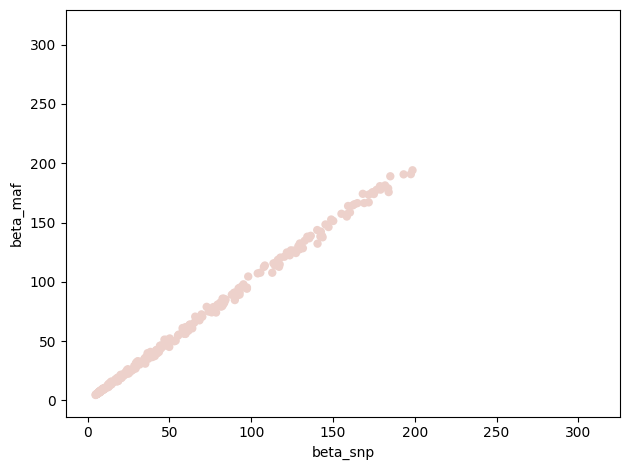

In [295]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'logP_mafs_ols',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

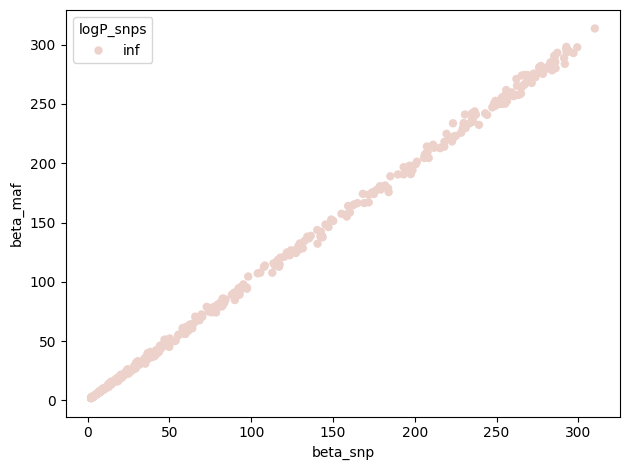

In [296]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'logP_snps',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

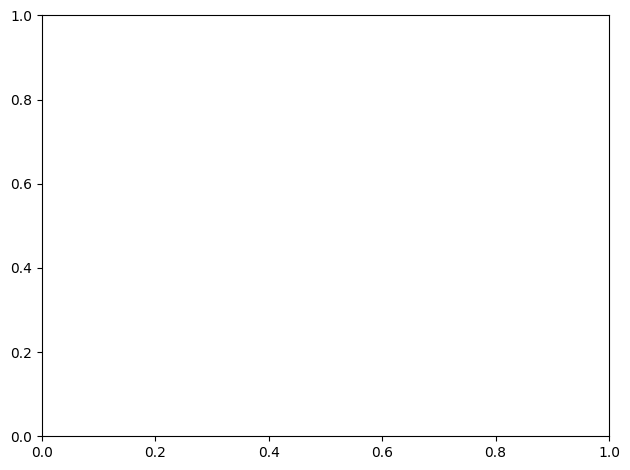

In [297]:
sns.scatterplot(x='logP_snps', y='logP_mafs_ols',data=to_compare, hue= 'beta_snp',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()